In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
features = pd.read_csv('/content/features.csv')
stores = pd.read_csv('/content/stores.csv')

In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [6]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


**Data preprocessing**

First, we need to merge datasets.

1- Merge the train and test datasets as we want to predict the future sales (Weekly_Sales). Add a column 'Set' so we can re-split later.

2- Merge the rest.

In [8]:
train['Set'] = 'train'
test['Set'] = 'test'
data = pd.concat([train, test], sort=False)


data = data.merge(features, on=['Store', 'Date'], how='left')
data = data.merge(stores, on='Store', how='left')

data.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Set,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,train,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,train,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,train,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,train,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,train,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
5,1,1,2010-03-12,21043.39,False,train,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315
6,1,1,2010-03-19,22136.64,False,train,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False,A,151315
7,1,1,2010-03-26,26229.21,False,train,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False,A,151315
8,1,1,2010-04-02,57258.43,False,train,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False,A,151315
9,1,1,2010-04-09,42960.91,False,train,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False,A,151315


**Data handling & ordering**

In [9]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Store','Dept','Date'])
data.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Set,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,train,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,train,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,train,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,train,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,train,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
5,1,1,2010-03-12,21043.39,False,train,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315
6,1,1,2010-03-19,22136.64,False,train,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False,A,151315
7,1,1,2010-03-26,26229.21,False,train,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False,A,151315
8,1,1,2010-04-02,57258.43,False,train,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False,A,151315
9,1,1,2010-04-09,42960.91,False,train,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False,A,151315


**Time-based features**

In [10]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
pd.set_option('display.max_columns', None)
data.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Set,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Year,Month,Week
0,1,1,2010-02-05,24924.50,False,train,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5
1,1,1,2010-02-12,46039.49,True,train,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,2010,2,6
2,1,1,2010-02-19,41595.55,False,train,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,2010,2,7
3,1,1,2010-02-26,19403.54,False,train,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,2010,2,8
4,1,1,2010-03-05,21827.90,False,train,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,2010,3,9
5,1,1,2010-03-12,21043.39,False,train,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315,2010,3,10
6,1,1,2010-03-19,22136.64,False,train,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False,A,151315,2010,3,11
7,1,1,2010-03-26,26229.21,False,train,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False,A,151315,2010,3,12
8,1,1,2010-04-02,57258.43,False,train,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False,A,151315,2010,4,13
9,1,1,2010-04-09,42960.91,False,train,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False,A,151315,2010,4,14


Lag & rolling features (the “memory” of the series):

Lag 1: last week’s sales.

MA4: 4-week moving average (using .shift(1) first so we don’t leak current week’s target into features).👇🏻

In [11]:
data['Weekly_Sales_Lag1'] = data.groupby(['Store','Dept'])['Weekly_Sales'].shift(1)
data['Weekly_Sales_MA4'] = (data.groupby(['Store','Dept'])['Weekly_Sales'].shift(1).rolling(4).mean())
pd.set_option('display.max_columns', None)
data.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Set,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Year,Month,Week,Weekly_Sales_Lag1,Weekly_Sales_MA4
0,1,1,2010-02-05,24924.50,False,train,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5,NaN,NaN
1,1,1,2010-02-12,46039.49,True,train,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,2010,2,6,24924.50,NaN
2,1,1,2010-02-19,41595.55,False,train,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,2010,2,7,46039.49,NaN
3,1,1,2010-02-26,19403.54,False,train,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,2010,2,8,41595.55,NaN
4,1,1,2010-03-05,21827.90,False,train,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,2010,3,9,19403.54,32990.7700
5,1,1,2010-03-12,21043.39,False,train,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315,2010,3,10,21827.90,32216.6200
6,1,1,2010-03-19,22136.64,False,train,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False,A,151315,2010,3,11,21043.39,25967.5950
7,1,1,2010-03-26,26229.21,False,train,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False,A,151315,2010,3,12,22136.64,21102.8675
8,1,1,2010-04-02,57258.43,False,train,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False,A,151315,2010,4,13,26229.21,22809.2850
9,1,1,2010-04-09,42960.91,False,train,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False,A,151315,2010,4,14,57258.43,31666.9175


Split back to train/test:

After creating features on the combined frame, we split back using the flags we added.

In [12]:
train = data[data['Set']=='train']
test  = data[data['Set']=='test']

Drop rows that can’t support lag windows (train only)

In [13]:
train = train.dropna(subset=['Weekly_Sales_Lag1','Weekly_Sales_MA4'])

**Features and target**

In [14]:
features_cols = [
    'Store','Dept','Size','IsHoliday_y','Temperature','Fuel_Price','CPI','Unemployment',
    'Year','Month','Week','Weekly_Sales_Lag1','Weekly_Sales_MA4']
X_train = train[features_cols]
y_train = train['Weekly_Sales']
X_test  = test[features_cols]

**Linear regression**

In [15]:
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_train)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_lr)))

Linear Regression RMSE: 6309.452376363503


**Time aware validation**

In [16]:
train_sorted = train.sort_values('Date')
# take last 20% of weeks as validation
cutoff_date = train_sorted['Date'].quantile(0.8)

train_data = train_sorted[train_sorted['Date'] <= cutoff_date]
val_data   = train_sorted[train_sorted['Date'] > cutoff_date]

X_tr, y_tr = train_data[features_cols], train_data['Weekly_Sales']
X_val, y_val = val_data[features_cols], val_data['Weekly_Sales']

**Linear Regression**

In [17]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)
val_pred_lr = lr.predict(X_val)
rmse_lr = np.sqrt(mean_squared_error(y_val, val_pred_lr))
print("Validation RMSE (Linear Regression):", rmse_lr)

Validation RMSE (Linear Regression): 3248.050821230077


In [19]:
import lightgbm as lgb
import xgboost as xgb

**XGBoost**

In [20]:
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_tr, y_tr)
val_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, val_pred_xgb))
print("Validation RMSE (XGBoost):", rmse_xgb)

Validation RMSE (XGBoost): 2964.7084123122213


**LightGBM**

In [21]:
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
lgb_model.fit(X_tr, y_tr)
val_pred_lgb = lgb_model.predict(X_val)
rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
print("Validation RMSE (LightGBM):", rmse_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 328635, number of used features: 13
[LightGBM] [Info] Start training from score 16079.231086
Validation RMSE (LightGBM): 2934.840749096561


In conclusion, LightGBM achieved an RMSE of 2934.84, which is the lowest error and therefore the best performance among all models.

**Rolling averages and seasonal decomposition**

In [23]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# picking one store and department to visualize
store_id = 1
dept_id = 1

# filtering only that store and department from train
series = (train[(train['Store']==store_id) & (train['Dept']==dept_id)].set_index('Date').sort_index()['Weekly_Sales'])

Applying rolling average

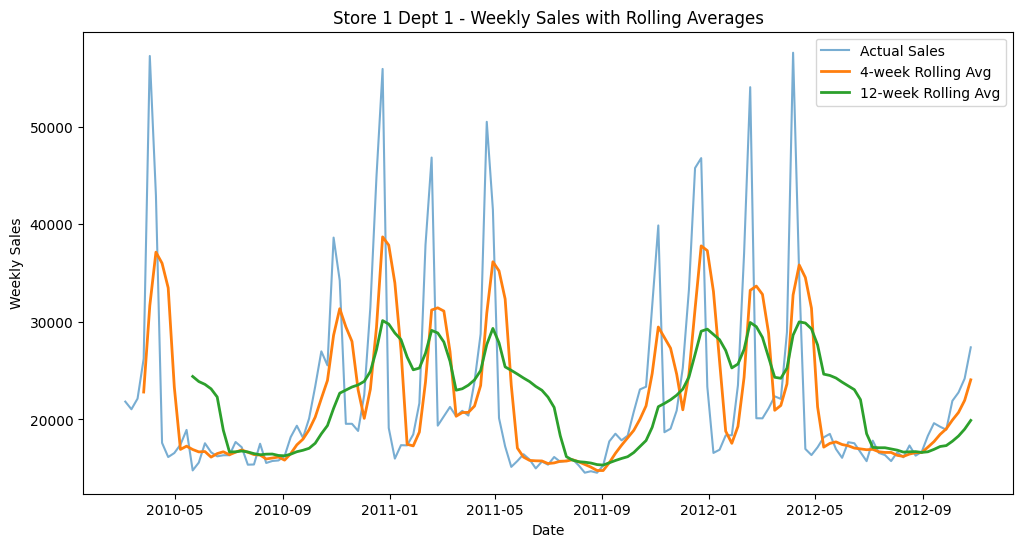

In [24]:
plt.figure(figsize=(12,6))
plt.plot(series, label="Actual Sales", alpha=0.6)

# 4-week rolling average
plt.plot(series.rolling(4).mean(), label="4-week Rolling Avg", linewidth=2)

# 12-week rolling average
plt.plot(series.rolling(12).mean(), label="12-week Rolling Avg", linewidth=2)

plt.title(f"Store {store_id} Dept {dept_id} - Weekly Sales with Rolling Averages")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

comment

Applying seasonal decomposition

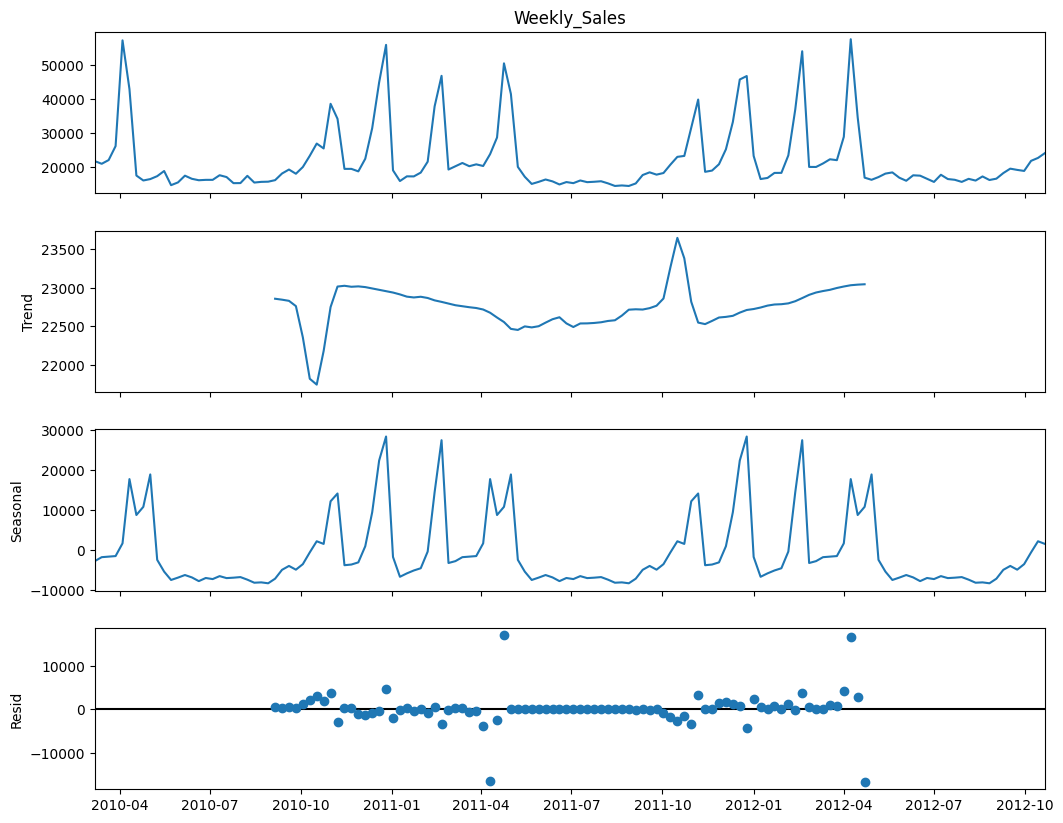

In [25]:
series = series.asfreq('W', method='pad')

# decompose (period=52 means ~1 year seasonality in weekly data)
result = seasonal_decompose(series, model='additive', period=52)

fig = result.plot()
fig.set_size_inches(12, 9)
plt.show()